In [1]:
import petri_net_toolkit as pntk
from petri_net_toolkit.nets import *
import numpy as np
import torch
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random
from tqdm import tqdm
import rl_utils

In [2]:
env = TestNet_Colored('test_net')

# random init env
init_vec = np.round(10*np.random.rand(env.observation_space[0]))
# init_dict = dict()
# for i in range(len(init_vec)):
#     init_dict['p'+str(i+1)] = {'default': 0, 'default_error':0}
# init_dict['p1']['default'] = 30
# print(init_dict)
env.initialize_net()
# env.define_initial(initial_dict=init_dict)
env.reset()
env.draw_net()

/Users/jason/Documents/SJTU_pro/Projects/DTG/PetriNets/petri_net_toolkit/petri_nets.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pt_matrix.loc[element.name] = np.zeros(len(self.pt_matrix.columns))


In [3]:
env.observation_space

(16,)

In [4]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return  F.sigmoid(self.fc2(x))

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps      # PPO-Clip epsilon
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        bernolli = torch.distributions.Bernoulli(probs)
        action_vector = bernolli.sample().reshape(-1).numpy()
        return action_vector

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1-dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        bernoulli = torch.distributions.Bernoulli(self.actor(states))
        old_log_probs = bernoulli.log_prob(actions).sum().detach()

        for _ in range(self.epochs):
            bernoulli_ = torch.distributions.Bernoulli(self.actor(states))
            log_probs = bernoulli_.log_prob(actions).sum()
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps)
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0) 
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            # for name, param in self.actor.named_parameters():
            #     if param.grad is not None:
            #         print(f'Parameter: {name}, Gradient norm: {torch.norm(param.grad)}')


In [6]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.99
lmbda = 0.95
epochs = 10
eps = 0.2


In [7]:
state_dim = env.observation_space[0]
action_dim = env.action_space
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

In [8]:
state = env.observation_space
print(state)
print(state_dim)

(16,)
16


In [9]:
return_list = []
output_traj = []
dict_list = []
output_time = []
for i in range(30):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            done = False
            max_T = 200
            T = 0
            traj_8 = []
            trig = np.zeros(env.action_dim)
            ## sample one sequence
            while (not done) and (T < max_T):
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state  
                episode_return += reward
                traj_8.append(env.places['p8'].token['default'])
                T += 1
            output_traj.append(traj_8)
            output_time.append(env.act_time)
            return_list.append(episode_return)
            dict_list.append(transition_dict)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                    'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/7x/vkxy_bn547d757f8znyxd6rh0000gn/T/ipykernel_66775/3809666563.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 29: 100%|██████████| 50/50 [00:00<00:00, 129.01it/s, episode=1500, return=5010.764]


In [10]:
k = 1
for i in range(len(dict_list[k]['states'])):
    print(dict_list[k]['states'][i])

[30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 29  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
[ 0 27  0  1  1  0  0  0  0  0  1  0  0  0  0  0]
[ 0 27  0  1  0  0  0  1  0  0  1  0  0  0  0  0]
[ 0 25  0  2  1  0  0  1  0  0  1  0  0  0  0  0]
[ 0 22  0  3  2  0  0  1  0  0  2  0  0  0  0  0]
[ 0 20  0  3  3  0  0  2  0  0  2  0  0  0  0  0]
[ 0 19  0  3  3  0  0  3  0  0  2  0  0  0  0  0]
[ 0 18  0  4  3  0  0  3  0  0  2  0  0  0  0  0]
[ 0 18  0  4  2  0  0  4  0  0  2  0  0  0  0  0]
[ 0 18  0  5  1  0  0  4  0  0  2  0  0  0  0  0]
[ 0 16  0  5  2  0  0  5  0  0  2  0  0  0  0  0]
[ 0 14  0  5  3  0  0  6  0  0  2  0  0  0  0  0]
[ 0 12  1  5  3  0  0  7  0  0  2  0  0  0  0  0]
[ 0 10  0  5  4  0  0  9  0  0  2  0  0  0  0  0]
[ 0  8  0  5  5  0  0 10  0  0  2  0  0  0  0  0]
[ 0  7  0  5  5  0  0 11  0  0  2  0  0  0  0  0]
[ 0  5  0  5  6  0  0 12  0  0  2  0  0  0  0  0]


In [11]:
for a in env.actions:
    print(a.name)

for i in range(len(dict_list[k]['actions'])):
    print(dict_list[k]['actions'][i])

t2
t3
t4
t5
t6
t7
t8
[0. 1. 0. 0. 1. 1. 1.]
[0. 0. 1. 0. 1. 1. 1.]
[1. 0. 1. 0. 1. 1. 1.]
[0. 1. 1. 0. 0. 0. 0.]
[0. 1. 0. 1. 1. 1. 0.]
[0. 1. 1. 0. 0. 0. 1.]
[1. 1. 1. 0. 0. 0. 1.]
[0. 1. 1. 0. 1. 0. 0.]
[0. 1. 1. 1. 1. 1. 0.]
[0. 1. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 1. 1. 1.]
[0. 1. 0. 0. 0. 1. 1.]
[0. 1. 1. 0. 1. 0. 1.]
[0. 1. 1. 0. 1. 0. 0.]
[1. 1. 1. 0. 1. 1. 0.]
[0. 1. 1. 1. 1. 0. 1.]
[0. 1. 1. 0. 1. 0. 0.]
[1. 0. 1. 1. 0. 1. 1.]
[0. 1. 1. 0. 1. 0. 1.]
[1. 1. 1. 0. 0. 1. 1.]
[0. 1. 1. 1. 0. 1. 0.]
[1. 1. 1. 0. 1. 1. 1.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 1. 1. 0. 1. 0. 0.]
[0. 1. 1. 0. 1. 0. 0.]
[1. 0. 1. 0. 1. 1. 0.]
[0. 1. 1. 0. 1. 0. 0.]
[1. 1. 1. 0. 1. 0. 0.]
[1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 0. 1.]
[1. 0. 1. 0. 0. 1. 0.]
[1. 1. 1. 0. 1. 1. 0.]
[1. 0. 1. 0. 1. 0. 0.]
[1. 1. 1. 0. 1. 0. 0.]
[1. 1. 1. 0. 1. 1. 0.]
[1. 1. 1. 0. 0. 1. 1.]
[1. 1. 1. 0. 1. 0. 0.]
[1. 1. 1. 1. 1. 0. 1.]
[0. 1. 1. 1. 1. 0. 0.]


In [12]:
for i in range(len(dict_list[k]['rewards'])):
    print(dict_list[k]['rewards'][i])

-0.8
-48.39999997938847
-67.39999997938847
-48.96817349166835
138.79892315677975
-49.541086228651864
-69.81313073402437
144.80957718711326
121.79877179767351
-31.51775950786863
141.53897503246841
-56.73718415854559
147.56308241674634
150.03992548553808
100.17996963892978
325.8714318370241
142.2779575618177
113.79999960838079
149.32191230531154
-93.79401209934947
104.4862520508822
114.98597421718644
-28.999999979388463
151.29559093523025
195.59999958776925
166.59999960838078
166.84355600711234
195.39999958776926
347.39999919615
357.39999917553854
-29.39999997938846
147.59999960838078
176.79999958776926
-0.8
-29.799999979388463
-19.799999999999997
-0.8
179.99999958776928
180.39999958776926


In [13]:
print(output_traj)

[[0, 1, 2, 3, 4, 5, 6, 7, 7, 9, 10, 10, 12, 13, 15, 16, 17, 17, 18, 19, 20, 21, 21, 21, 21, 22, 22, 22, 23], [0, 0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7, 9, 10, 11, 12, 12, 13, 14, 14, 15, 16, 17, 18, 19, 21, 23, 23, 24, 25, 25, 25, 25, 25, 26, 27], [1, 2, 3, 4, 5, 5, 5, 6, 6, 6, 7, 9, 9, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 24], [0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 10, 11, 13, 14, 15, 15, 16, 17, 18, 18, 18, 19, 19, 20, 21, 22, 22, 23, 24], [0, 1, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 14, 14, 14, 15, 16, 17, 18, 19, 20, 20, 20, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 24], [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 10, 11, 12, 13, 14, 14, 15, 16, 16, 17, 17, 18, 20, 20, 20, 21, 22, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24], [1, 2, 2, 3, 3, 4, 5, 7, 8, 9, 9, 10, 10, 11, 11, 12, 13, 14, 15, 17, 18, 19, 20, 20, 22, 23, 23, 24, 24, 24, 24], [0, 1, 1, 2, 3, 3, 4, 5, 6, 7, 7, 8, 9, 10, 12, 14, 14, 15, 16, 17, 18, 18, 19, 19

1500


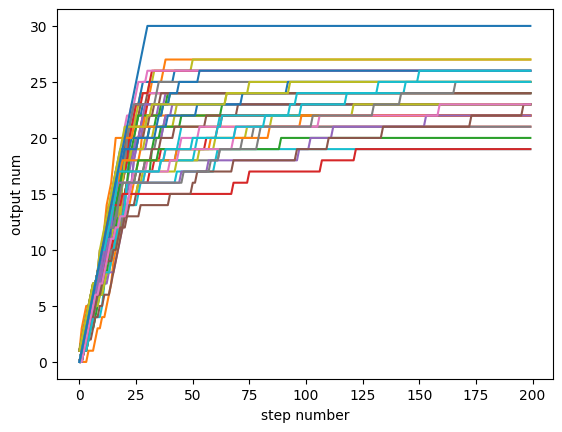

In [14]:
# ======= plot output traj =======
max_traj = max(len(traj) for traj in output_traj)
step_num = range(max_traj)
for traj in output_traj:
    traj.extend([traj[-1]] * (max_traj - len(traj)))
    
max_step = 200
for i in range(40):
    plt.plot(step_num[:max_step], output_traj[i][:max_step])

plt.plot(step_num[:max_step], output_traj[-1][:max_step])
plt.xlabel('step number')
plt.ylabel('output num')
print(len(output_traj))

1071.7368892624954


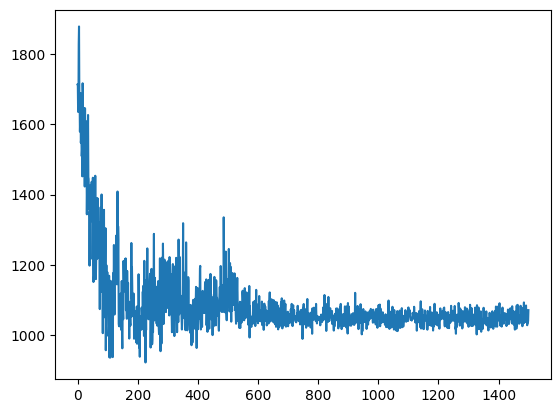

In [15]:
# ======= plot min finish time =======

print(output_time[-1])
plt.plot(range(len(output_time)), output_time)

[2757.70104235086, 3584.24054864844, 3086.286672678328, 3097.486666449355, 2855.861172624478, 2809.434756232513, 2997.9269339226435, 2612.9408774559606, 3719.66021480854, 2695.7345730998345, 3421.4812502019804, 2769.4225354308514, 3158.774069361816, 3608.723019424323, 3003.775951282964, 3204.471260939024, 3724.2598885265884, 3191.27297130182, 3237.786600950399, 2196.2107368202487, 3582.099594115267, 2676.658786721043, 2958.1908762483645, 2642.4018091804464, 3146.779160007691, 2817.4227803785616, 2663.6453845037527, 2490.8010915364307, 2867.892847882474, 3453.7571484703894, 3378.3290791654695, 2970.507851098529, 2464.2774932799407, 2292.344556696712, 2728.290585548646, 2773.1470767647024, 2966.8027503318417, 3403.7523734851884, 3559.725210765614, 3504.9636668169646, 2948.8262849598436, 2940.7346567219774, 2588.78637667854, 2266.568876544633, 2410.3133969834403, 2954.7774588855714, 2957.2851542861517, 2797.034733317416, 2237.795558615029, 2962.5512938354495, 3340.423161425944, 2776.17701

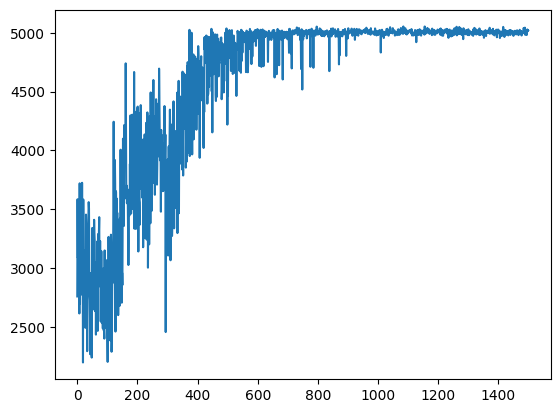

In [16]:
print(return_list)
plt.plot(range(len(return_list)), return_list)

In [17]:
# test_input = torch.rand(state_dim)
# test_output = agent.actor(test_input)
# print(agent.actor.state_dict())

In [18]:
probs = torch.tensor([0.8, 0.9, 0.6, 0.1])

# 创建Bernoulli分布对象
bernoulli = torch.distributions.Bernoulli(probs)

# 定义采样序列
samples = torch.tensor([1.0, 1.0, 1.0, 0.0])

# 计算采样序列的概率
log_probs = bernoulli.log_prob(samples)
log_probs_ = log_probs.sum()
prob = torch.exp(log_probs).prod().item()
print(log_probs)
print(log_probs_)
print(prob)
print(torch.exp(log_probs_))

tensor([-0.2231, -0.1054, -0.5108, -0.1054])
tensor(-0.9447)
0.3888000249862671
tensor(0.3888)


In [19]:
env.draw_net('colored_PPO.png')